# Week 4 - Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder that best describes corpus words in their local linguistic contexts, and using their locations in that space to evaluate distances between words such that context distances are preserved. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics so that distances between them are consistently superior, but harder to communicate. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can be used to explore discursive culture.

For this notebook we will be using the following packages

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Intro

intro stuff ...

# Getting our corpuses

Instead of downloading our corpora, we have download them ahead of time, a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `data/grimmerPressReleases`. So we will load them into a DataFrame, to do this first we need to define a function to convert directories of text files into DataFrames.

In [2]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [3]:
dataDir = 'data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Kennedy,data/grimmerPressReleases/Kennedy/01Apr2005Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
10,Kennedy,data/grimmerPressReleases/Kennedy/01Dec2005Ken...,FOR IMMEDIATE RELEASE Washington ...
20,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2006Ken...,FOR IMMEDIATE RELEASE Fact sheet...
30,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2007Ken...,FOR IMMEDIATE RELEASE Washington ...
40,Kennedy,data/grimmerPressReleases/Kennedy/01Jun2007Ken...,FOR IMMEDIATE RELEASE BOSTON MA Se...
50,Kennedy,data/grimmerPressReleases/Kennedy/01Mar2007Ken...,FOR IMMEDIATE RELEASE Washington ...
60,Kennedy,data/grimmerPressReleases/Kennedy/01May2007Ken...,FOR IMMEDIATE RELEASE The President ...
70,Kennedy,data/grimmerPressReleases/Kennedy/01Nov2007Ken...,FOR IMMEDIATE RELEASE Washington DC...
80,Kennedy,data/grimmerPressReleases/Kennedy/02Aug2006Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
90,Kennedy,data/grimmerPressReleases/Kennedy/02Feb2005Ken...,FOR IMMEDIATE RELEASE The Preside...


We also want to remove stop words and stem, but tokenizing requires two steps. Word2Vec wants to know the sentence structure as well as simply the words, so the tokenizing is slightly different this time.

In [4]:
#Define the same function as last week
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

#initialize our stemmer and our stop words
stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')
wordnet = nltk.stem.WordNetLemmatizer()

In [5]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [normlizeTokens(s, stopwordLst = stop_words_nltk, stemmer = None) for s in x])

senReleasesDF[:100:10]

,category,filePath,text,tokenized_sents,normalized_sents
0,Kennedy,data/grimmerPressReleases/Kennedy/01Apr2005Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
10,Kennedy,data/grimmerPressReleases/Kennedy/01Dec2005Ken...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, D, C, T...","[[immediate, release, washington, c, today, se..."
20,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2006Ken...,FOR IMMEDIATE RELEASE Fact sheet...,"[[FOR, IMMEDIATE, RELEASE, Fact, sheets, on, B...","[[immediate, release, fact, sheets, bush, plan..."
30,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2007Ken...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, D, C, T...","[[immediate, release, washington, c, today, u,..."
40,Kennedy,data/grimmerPressReleases/Kennedy/01Jun2007Ken...,FOR IMMEDIATE RELEASE BOSTON MA Se...,"[[FOR, IMMEDIATE, RELEASE, BOSTON, MA, Senator...","[[immediate, release, boston, senator, edward,..."
50,Kennedy,data/grimmerPressReleases/Kennedy/01Mar2007Ken...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, DC, Tod...","[[immediate, release, washington, dc, today, s..."
60,Kennedy,data/grimmerPressReleases/Kennedy/01May2007Ken...,FOR IMMEDIATE RELEASE The President ...,"[[FOR, IMMEDIATE, RELEASE, The, President, is,...","[[immediate, release, president, wrong, veto, ..."
70,Kennedy,data/grimmerPressReleases/Kennedy/01Nov2007Ken...,FOR IMMEDIATE RELEASE Washington DC...,"[[FOR, IMMEDIATE, RELEASE, Washington, DC, Sen...","[[immediate, release, washington, dc, senators..."
80,Kennedy,data/grimmerPressReleases/Kennedy/02Aug2006Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, impo..."
90,Kennedy,data/grimmerPressReleases/Kennedy/02Feb2005Ken...,FOR IMMEDIATE RELEASE The Preside...,"[[FOR, IMMEDIATE, RELEASE, The, President, gav...","[[immediate, release, president, gave, effecti..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer

In [6]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object the words each have a vector, to access the vector directly use the square braces (`__getitem__`) method:

In [7]:
senReleasesW2V['president'][:10] #Shortening because it's very large

array([ 2.3201859 , -1.59573579, -2.3535831 ,  1.17507434,  0.80890542,
       -0.07561323,  0.24201433, -1.63457263,  2.04466867,  0.57714665], dtype=float32)

If you want the full matrix, `syn0` stores all the vectors

In [8]:
senReleasesW2V.syn0

array([[ -1.77841783e-01,   6.45595253e-01,  -3.56653064e-01, ...,
         -1.12636960e+00,   7.98077226e-01,   5.41791797e-01],
       [  1.23999059e-01,   2.20621943e+00,   5.62630415e-01, ...,
         -1.96249402e+00,  -7.91522324e-01,  -5.90319447e-02],
       [ -1.49650562e+00,  -1.72481990e+00,   2.64760256e+00, ...,
          4.97493535e-01,   1.18446004e+00,  -2.72109652e+00],
       ..., 
       [  5.85300550e-02,   6.21598884e-02,   4.44221571e-02, ...,
          4.23464272e-03,  -5.93440831e-02,   5.11041097e-02],
       [  1.71879716e-02,   3.35917138e-02,   3.24738026e-02, ...,
         -2.00784672e-02,  -4.89017833e-03,   5.55787608e-02],
       [ -2.13445304e-03,   1.62330852e-03,   1.09323747e-02, ...,
          4.88485023e-02,  -3.23136263e-02,   7.26962984e-02]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words

In [9]:
senReleasesW2V.index2word[10]

'american'

Now we can look at a few things that come from the vectors, find similar vectors:

In [10]:
senReleasesW2V.most_similar('president')

[('presidents', 0.7720838189125061),
 ('administration', 0.7515982985496521),
 ('administrations', 0.6465076208114624),
 ('cheney', 0.5936229825019836),
 ('george', 0.5707100629806519),
 ('sticklers', 0.5640989542007446),
 ('quoting', 0.5463705062866211),
 ('responds', 0.5375101566314697),
 ('republican', 0.5290516018867493),
 ('chose', 0.5106145143508911)]

Find what doesn't match in some set

In [11]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Make comparisons:

In [12]:
senReleasesW2V.most_similar(positive=['administration', 'manufacturing'], negative = ['taxation'])#Need a better example

[('slash', 0.4592266082763672),
 ('training', 0.45880424976348877),
 ('mep', 0.435918927192688),
 ('jeopardizes', 0.43018120527267456),
 ('develop', 0.42883333563804626),
 ('carpenters', 0.42882099747657776),
 ('train', 0.42424964904785156),
 ('innovative', 0.402671217918396),
 ('securing', 0.4024003744125366),
 ('reconstructing', 0.39941227436065674)]

Or save for use later

In [13]:
senReleasesW2V.save("data/senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset that we want to plot. Lets look at the top words from the set:

In [14]:
numWords = 50
targetWords = senReleasesW2V.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix

In [15]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.17784178,  0.64559525, -0.35665306, ..., -1.1263696 ,
         0.79807723,  0.5417918 ],
       [ 0.12399906,  2.20621943,  0.56263041, ..., -1.96249402,
        -0.79152232, -0.05903194],
       [-1.49650562, -1.7248199 ,  2.64760256, ...,  0.49749354,
         1.18446004, -2.72109652],
       ..., 
       [-0.43189272, -0.51287293,  3.72522211, ..., -1.70198584,
         0.01688601, -0.61169225],
       [-0.06028287,  2.07287073,  0.15565167, ..., -0.56822544,
        -1.57762659,  1.03110027],
       [-0.7361362 ,  1.48159862,  1.82499945, ...,  0.92793196,
        -0.26942873, -0.82958955]], dtype=float32)

Then we can use PCa to reduce most of the dimesions, and T-SNE for the last 48.

In [17]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)

tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

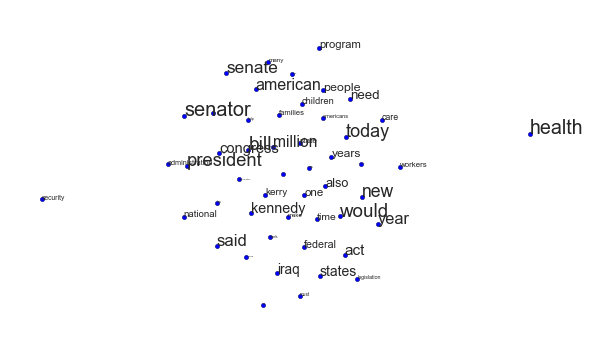

In [18]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1])
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

# Doc2Vec

We can instead of looking at just how the words embed in the space, look at how the different spaces relate to each other. First lets load our data, some abstracts of physics papers from the 1950s.

In [19]:
apsDF = pandas.read_csv('data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [20]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [21]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk))

In [22]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec

In [23]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get the vectors for the tags/documents, just like words

In [24]:
apsD2V.docvecs[1952]

array([  2.77983062e-02,  -1.43952779e-02,  -1.06178530e-01,
         3.92271355e-02,  -3.72370780e-02,   7.23966658e-02,
         1.91531733e-01,   7.15262815e-02,   4.66963351e-02,
         6.39228150e-02,  -8.08391795e-02,  -1.09827973e-01,
        -4.24897810e-03,  -1.11823209e-01,   6.97774366e-02,
        -2.09850608e-03,  -1.70218386e-02,  -1.33914307e-01,
         4.66687838e-03,   8.20764229e-02,   1.73146613e-02,
        -5.21396101e-02,  -9.26899686e-02,   2.30742395e-02,
        -2.94208992e-02,  -4.71711196e-02,  -1.17024951e-01,
         1.45977646e-01,  -1.37479544e-01,  -1.08740469e-02,
         1.06332395e-02,   3.67540270e-02,  -1.21985115e-01,
         1.21715799e-01,   5.08344285e-02,  -1.84310406e-01,
         1.05498042e-02,  -1.32046998e-01,   1.28025800e-01,
         7.16430172e-02,   9.76479426e-02,  -3.29876393e-02,
        -4.14050482e-02,   8.94447044e-02,   8.43529329e-02,
         9.47565585e-02,   3.80647704e-02,   2.00347062e-02,
        -7.37624690e-02,

And the words are still accessed the same way

In [25]:
apsD2V['electron']

array([-0.0038661 ,  0.09406455,  0.1198468 ,  0.01598788,  0.23490871,
       -0.02241622,  0.03530223,  0.13758129, -0.08424953,  0.00289275,
       -0.01826715, -0.07540332,  0.03460044,  0.06909078, -0.07492179,
        0.35018981, -0.11097012,  0.13899992, -0.08263991, -0.19133331,
        0.12319691,  0.08837323,  0.04758322,  0.05626663,  0.16806071,
        0.05057461, -0.05512555, -0.05309496, -0.26877275, -0.11908299,
        0.11032751, -0.17331778, -0.28619602, -0.15546291,  0.01179495,
        0.10487287, -0.18939537, -0.11055965, -0.00132522, -0.19114865,
        0.2100836 ,  0.0577289 , -0.04420147,  0.05965301, -0.01769086,
       -0.00524232, -0.12961406, -0.01414549, -0.02068962, -0.19169855,
       -0.00564144,  0.14166567,  0.05846943, -0.12988226,  0.03755698,
       -0.02755947, -0.10078627, -0.08390012, -0.2404509 ,  0.00725177,
        0.152391  , -0.13230561,  0.09525262, -0.1690923 ,  0.00145873,
        0.03461511,  0.21650904, -0.12438574, -0.11139014,  0.01

We can still use the 

In [26]:
apsD2V.most_similar(positive = ['boltzmann', 'schroedinger'], negative = ['statistical'], topn = 5)

[('schrdinger', 0.7903362512588501),
 ('continuity', 0.6520664691925049),
 ('secular', 0.643038809299469),
 ('integral', 0.6341717839241028),
 ('liouville', 0.6279487013816833)]

As well as vector algebra 

In [27]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'], apsD2V['positron'])
#The error message can be prevented by adding .reshape(1, -1) to both the inputs

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.3609384]], dtype=float32)

Because the documents have vectors we can compare them with each other, or even words

In [33]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

In [34]:
heatmapMatrix.shape

(8, 8)

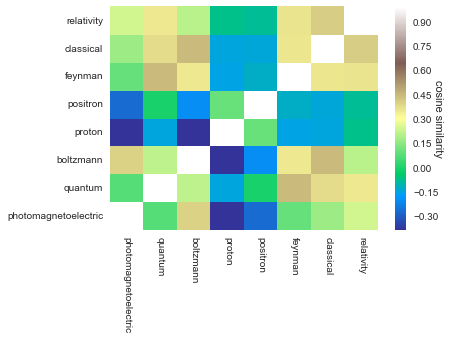

In [41]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Let's save the model in case we need it again

In [36]:
apsD2V.save('data/apsW2V')

We can then also load it

In [37]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

# The Score Function
Here, we use a model trained with resumes

In [40]:
resume_model  = gensim.models.word2vec.Word2Vec.load('data/resumeAll.short.model')

We can take a look at the vacabularies of this model.

In [43]:
vocab = resume_model.index2word

Let's load lots of job ads. Here, we only use a small sample of all of them. Uncomment this cell if you want to load more.

In [44]:
# with open('data/joblistings.merged.parsed.unique.grpbyyear.2010-2015.02.tsv','r') as tsv:
#     ads = [line.strip().split('\t') for line in tsv]
    
# adsDF = pandas.DataFrame(ads, columns = ads[0])
# reducedDF = adsDF[['hiringOrganization_organizationName', 'jobDescription', 'jobLocation_address_region', 'jobLocation_geo_latitude', 'jobLocation_geo_longitude', 'qualifications', 'responsibilities']][1:]
# N = reducedDF.shape[0]
# indices = random.sample(range(1, N+1), 100)
# sampleDF = reducedDF.iloc[indices]
# sampleDF['tokenized_sents'] = sampleDF['jobDescription'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
# sampleDF['normalized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: [normlizeTokens(s, vocab = vocab) for s in x])
# sampleDF.to_csv('data/SampleJobAds.csv')

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [65]:
sampleDF = pandas.DataFrame.from_csv('data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

,Unnamed: 0,hiringOrganization_organizationName,jobDescription,jobLocation_address_region,jobLocation_geo_latitude,jobLocation_geo_longitude,qualifications,responsibilities,tokenized_sents,normalized_sents
0,158844,"Golfsmith International, Inc.","""Sales Associate Tracking Code 220425-971 Job ...",California,33.91918,-118.41647,NaN,"""Ensure each Customer receives exceptional ser...","[[``, Sales, Associate, Tracking, Code, 220425...","[[sales, associate, tracking, code, job, descr..."
1,257645,Intel,For PHY system engineering team within the Wir...,NaN,NaN,NaN,NaN,NaN,"[[For, PHY, system, engineering, team, within,...","[[for, phy, system, engineering, team, within,..."
2,107875,Florida Hospital,*RN Medical Oncology PCU Orlando - Nights* Flo...,Florida,28.53834,-81.37924,NaN,NaN,"[[*RN, Medical, Oncology, PCU, Orlando, -, Nig...","[[medical, oncology, pcu, orlando, florida, ho..."
3,202394,Hitachi Data Systems,Title: Specialist Sales Account Representative...,NaN,NaN,NaN,NaN,NaN,"[[Title, :, Specialist, Sales, Account, Repres...","[[title, specialist, sales, account, represent..."
4,109675,Footprint Retail Services,**Footprint Retail Services** **Job Descriptio...,NaN,NaN,NaN,NaN,A Merchandiser must complete all assigned merc...,"[[**Footprint, Retail, Services**, **Job, Desc...","[[retail, job, title, retail, merchandiser, re..."
5,215973,Home Depot,Position Purpose: Provide outstanding service ...,Indiana,41.13060,-85.12886,NaN,Provide outstanding service to ensure efficien...,"[[Position, Purpose, :, Provide, outstanding, ...","[[position, purpose, provide, outstanding, ser..."
6,207524,Home Depot,The Asset Protection Specialist is primarily r...,New Jersey,40.21455,-74.61932,Must be eighteen years of age or older. Must p...,NaN,"[[The, Asset, Protection, Specialist, is, prim...","[[the, asset, protection, specialist, is, prim..."
7,64426,East West Bank,# Job Description East West Bank is one of the...,California,34.06862,-118.02757,NaN,We are currently seeking a Customer Service Ce...,"[[#, Job, Description, East, West, Bank, is, o...","[[job, description, east, west, bank, is, one,..."
8,245192,IBM,Job Description IBM is seeking to hire a Senio...,NaN,NaN,NaN,NaN,NaN,"[[Job, Description, IBM, is, seeking, to, hire...","[[job, description, ibm, is, seeking, to, hire..."
9,202429,Hitachi Data Systems,Title: Field Solutions Engineer Location: New ...,NaN,NaN,NaN,NaN,Job Functions;Specific duties in this role wil...,"[[Title, :, Field, Solutions, Engineer, Locati...","[[title, field, solutions, engineer, location,..."


Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb).

In [66]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [67]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

RuntimeError: we have only implemented score for hs

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [68]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

KeyError: 'likelihood'

Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

We can do some statistics. Unfortunately, we don't have a large sample here. So, it is just a toy version. Let's first look at the mean likelihood score of each hiring organization.

In [ ]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

We can look at the mean likelihood in each state.

In [ ]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

Increase the sample size if you want to do a more serious study.

# Projection

We can project word vectors to some dimension. To demonstrate this functionality, let's first load a model trained with New York Times news articles. 

In [73]:
nytimes_model = gensim.models.word2vec.Word2Vec.load_word2vec_format('data/nytimes_cbow.reduced.txt')

Define some convenient functions for getting dimensions. 

In [93]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [94]:
#nytimes_model['already']

Let's calculate three dimensions: gender, race, and class.

In [95]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [96]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [97]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word], Gender)[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word], Race)[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word], Class)[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [98]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/lo

Define some useful functions for plotting.

In [99]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

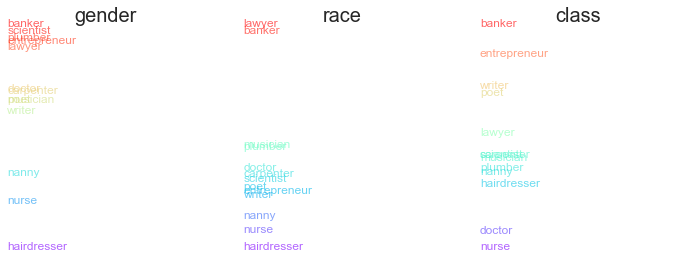

In [100]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods.

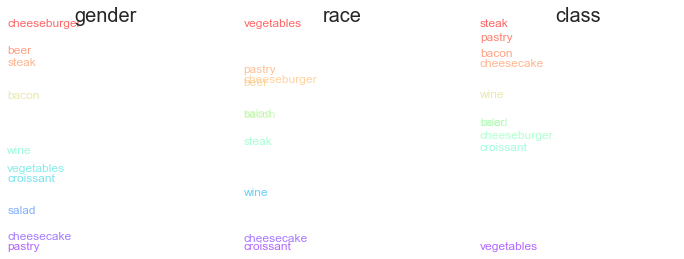

In [101]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports

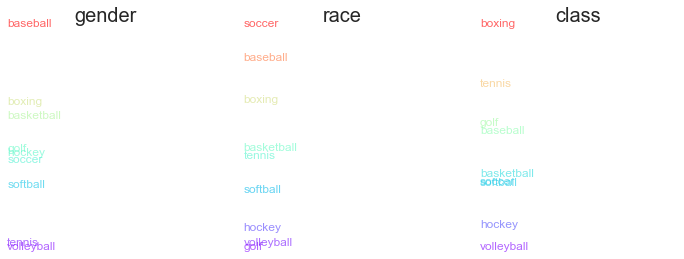

In [102]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()